# dcm file preprocessing

In [64]:
pwd # 경로 확인

'/home/ubuntu/gcubme4/Workspace/HM_LEE/spine_scoliosis/total_code'

In [65]:
#dcm zero padding & roi 마스크 생성 & resize
import glob
import os 
import pydicom
import cv2
import numpy as np
from read_roi import read_roi_zip
from PIL import Image
import matplotlib.pyplot as plt
from pydicom.uid import ImplicitVRLittleEndian
import nibabel as nib
import pandas as pd

In [66]:
def clahe(img):
    #img = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
    
    clahe=cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img2=clahe.apply(img)
    
    return img2

In [86]:
INPUT_FOLDER ='../datasets/compress_ori'

dcm_list=glob.glob(INPUT_FOLDER+"/*.dcm")
roi_zip_list=glob.glob(INPUT_FOLDER+"/*.zip")
dcm_list.sort()
roi_zip_list.sort()

print(len(roi_zip_list))
print(len(dcm_list))
# print(roi_zip_list[490])
# print(dcm_list[490])

74
74


# dcm_to_png_resize

In [136]:
def get_LUT_value(data, window, level):
    try:
        window = window[0]
    except TypeError:
        pass
    try:
        level = level[0]
    except TypeError:
        pass

    return np.piecewise(data,
                        [data <= (level - 0.5 - (window - 1) / 2),
                         data > (level - 0.5 + (window - 1) / 2)],
                        [0, 255, lambda data: ((data - (level - 0.5)) /
                         (window - 1) + 0.5) * (255 - 0)])

for i,dcm in enumerate(dcm_list):

    ds=pydicom.read_file(dcm)
    ArrayDicom = ds.pixel_array

    photometric_interpretation = ds.PhotometricInterpretation
    if photometric_interpretation == 'MONOCHROME1':
#         print("MONOCHROME1")
        ArrayDicom=255-get_LUT_value(ArrayDicom, ds.WindowWidth, ds.WindowCenter)
    elif photometric_interpretation == 'MONOCHROME2':
#         print("MONOCHROME2")
        ArrayDicom=get_LUT_value(ArrayDicom, ds.WindowWidth, ds.WindowCenter)
        
    diff=ArrayDicom.shape[0]-ArrayDicom.shape[1]
    diff_2=int(diff/2)
    if diff_2+diff_2 < diff:
        sum_numpy=np.zeros((ArrayDicom.shape[0],int(diff_2)))
        sum_numpy_=np.zeros((ArrayDicom.shape[0],int(diff_2)+1))
        tmp=np.append(sum_numpy, ArrayDicom, axis=-1)
        add_ArrayDicom=np.append(tmp, sum_numpy_, axis=-1)
    else:
        sum_numpy=np.zeros((ArrayDicom.shape[0],int(diff_2)))
        tmp=np.append(sum_numpy, ArrayDicom, axis=-1)
        add_ArrayDicom=np.append(tmp, sum_numpy, axis=-1)

    file_name=dcm[dcm.rindex('/')+1:-4]
#     print(file_name)
    img_resize = cv2.resize(add_ArrayDicom, (1024,1024)) #resize
    cv2.imwrite("../datasets/3st/inputt/img_%s.png"%file_name,img_resize)
    
    img = cv2.imread("../datasets/3st/inputt/img_%s.png"%file_name,cv2.IMREAD_GRAYSCALE)
    clahe_img=clahe(img)
    cv2.imwrite("../datasets/3st/input_CLAHEE/img_%s.png"%file_name,clahe_img)

#     print(ds.WindowWidth, ds.WindowCenter)
#     print(img_resize.shape)
#     plt.axis('off')
#     plt.imshow(img_resize, cmap='gray')
#     plt.show()

MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME2
MONOCHROME2
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME1
MONOCHROME2
MONOCHROME2


# roi_to_png_resize

In [69]:
for roi in roi_zip_list:

        if "0000.zip" in roi:
            ds=pydicom.read_file(roi.replace(".zip",".dcm"))
        else:
            ds=pydicom.read_file(roi.replace(".zip",".dcm"))

        ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ArrayDicom = ds.pixel_array
        rois = read_roi_zip(roi)
        roi_key=list(rois.keys())
        mask_tmp = np.zeros((ArrayDicom.shape[0], ArrayDicom.shape[1]), np.uint8)
        for j,nam in enumerate(roi_key):
            if rois[nam]['type']=='polygon' or rois[roi]['type'] == 'freehand':
                roi_xy=list(zip(rois[nam]['x'],rois[nam]['y']))
                roi_xy=np.array(roi_xy)
                mask = np.zeros((ArrayDicom.shape[0], ArrayDicom.shape[1]), np.uint8)
                mask2 = np.zeros((ArrayDicom.shape[0]+2, ArrayDicom.shape[1]+2), np.uint8)               
                roi_xy = roi_xy.reshape((-1,1,2))
                img = cv2.polylines(mask[:,:],np.int32([roi_xy]),True,(255,255,255)) #int32 오류떠서 넣음
                cv2.floodFill(img, mask2, (0,0), 255)
                img = cv2.bitwise_not(img)
                mask[:,:]=img
                mask_tmp[mask==255]=255
            else:
                print(rois[nam]['type'])
                print(roi)
                print("error!!!!!!!!!!!!!!!!!!!")


        diff=ArrayDicom.shape[0]-ArrayDicom.shape[1]
        diff_2=int(diff/2)
        if diff_2+diff_2 < diff:
            sum_numpy=np.zeros((ArrayDicom.shape[0],int(diff_2)))
            sum_numpy_=np.zeros((ArrayDicom.shape[0],int(diff_2)+1))
            tmp=np.append(sum_numpy, mask_tmp, axis=-1)
            add_mask=np.append(tmp, sum_numpy_, axis=-1)
        else:
            sum_numpy=np.zeros((ArrayDicom.shape[0],int(diff_2)))
            tmp=np.append(sum_numpy, mask_tmp, axis=-1)
            add_mask=np.append(tmp, sum_numpy, axis=-1)
            
        file_name=roi[roi.rindex('/')+1:-4]
        img_resize = cv2.resize(add_mask, (1024,1024)) #resize
        cv2.imwrite("../datasets/3st/maskk/img_%s.png"%file_name,img_resize)

#         print(img_resize.shape)
#         plt.axis('off')
#         plt.imshow(img_resize, cmap='gray')
#         plt.show()
        

# nii파일

In [127]:
import gzip
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import json
import cv2
import zipfile

In [128]:
INPUT_FOLDER ='../datasets/compress_ori'

dcm_list=glob.glob(INPUT_FOLDER+"/*.dcm")
roi_zip_list=glob.glob(INPUT_FOLDER+"/*.zip")
dcm_list.sort()
roi_zip_list.sort()

print(len(roi_zip_list))
print(len(dcm_list))
# print(roi_zip_list[490])
# print(dcm_list[490])

73
73


In [130]:
def open_niigz(path):
    proxy = nib.load(path)
    arr = proxy.get_fdata()
    #     arr = np.squeeze(arr,axis=-1)
    arr = arr[:, :, ::-1]
    arr = arr.T

    return arr[0]

PATH = '../datasets/compress_ori/'

for i,lis in enumerate(roi_zip_list):
#     print(lis)
    save_file_name=lis[lis.rindex('/')+1:-4]
    
    file_name=roi_zip_list[i][:-4]

    nii_path = sorted(glob.glob(file_name+ '/*.gz'))
    
    for j, path in enumerate(nii_path):
        
        a = open_niigz(path)
        name = path[path.rindex('/') + 1:].split('.')[0]
        
        if j==0:
            mask_tmp = a
        else:
            mask_tmp+=a
            
    if ".zip" in lis:
        ds=pydicom.read_file(lis.replace(".zip",".dcm"))

    ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    ArrayDicom = ds.pixel_array

    diff=ArrayDicom.shape[0]-ArrayDicom.shape[1]
    diff_2=int(diff/2)
    if diff_2+diff_2 < diff:
        sum_numpy=np.zeros((ArrayDicom.shape[0],int(diff_2)))
        sum_numpy_=np.zeros((ArrayDicom.shape[0],int(diff_2)+1))
        tmp=np.append(sum_numpy, mask_tmp, axis=-1)
        add_mask=np.append(tmp, sum_numpy_, axis=-1)
    else:
        sum_numpy=np.zeros((ArrayDicom.shape[0],int(diff_2)))
        tmp=np.append(sum_numpy, mask_tmp, axis=-1)
        add_mask=np.append(tmp, sum_numpy, axis=-1)

    
    img_resize = cv2.resize(add_mask, (1024,1024)) 
    cv2.imwrite("../datasets/3st/maskk/img_%s.png"%save_file_name,img_resize)
    
#     print(img_resize.shape)
#     plt.axis('off')
#     plt.imshow(img_resize, cmap='gray')
#     plt.show()

# 마스크와 원본 매칭

In [82]:
pwd

'/home/ubuntu/gcubme4/Workspace/HM_LEE/spine_scoliosis/total_code'

In [71]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


73    73


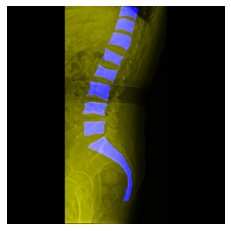

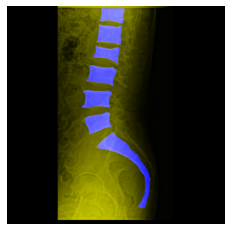

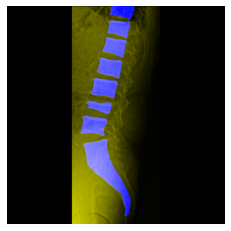

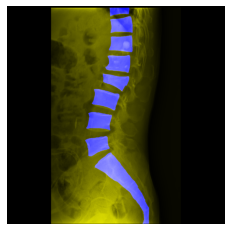

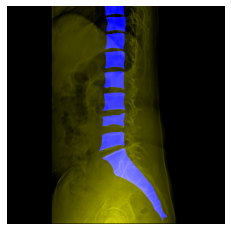

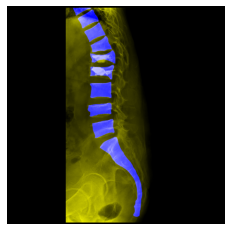

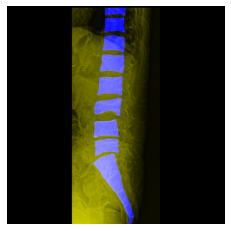

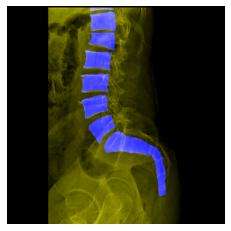

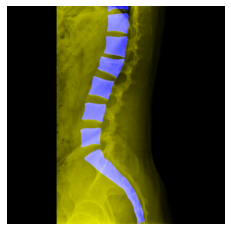

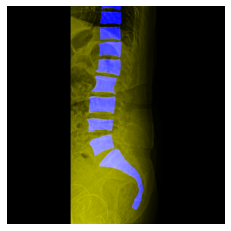

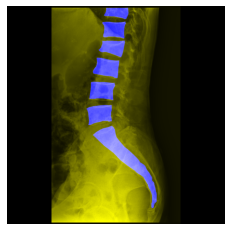

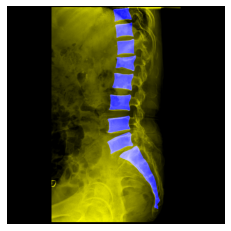

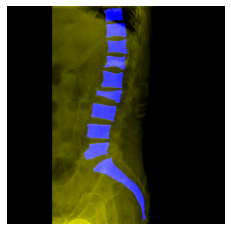

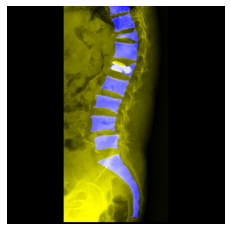

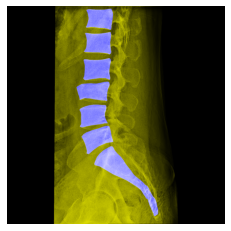

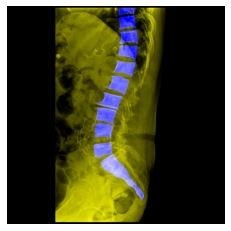

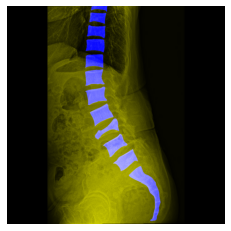

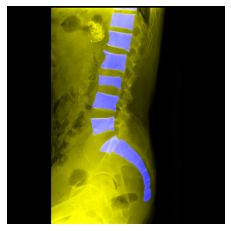

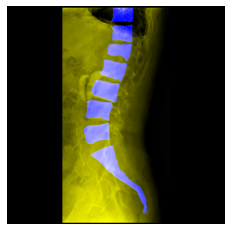

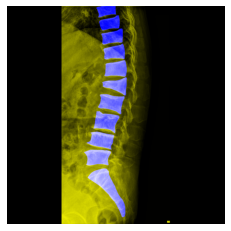

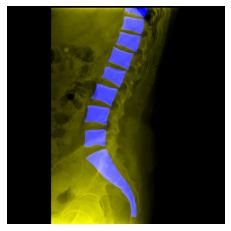

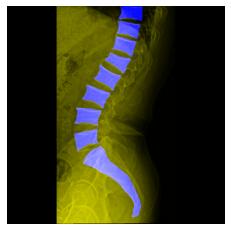

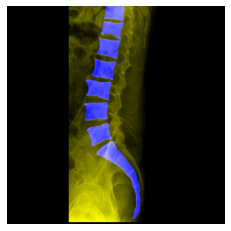

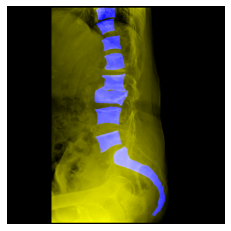

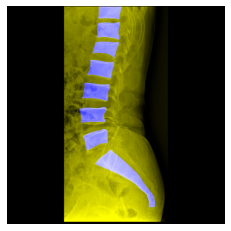

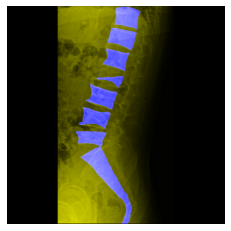

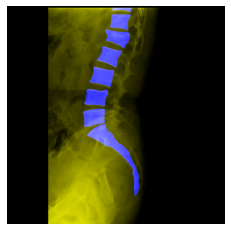

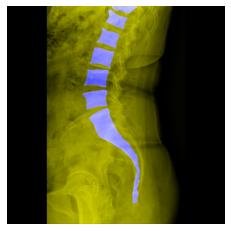

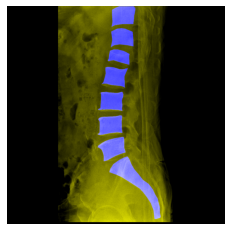

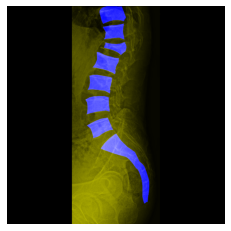

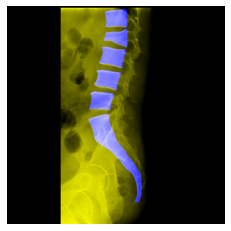

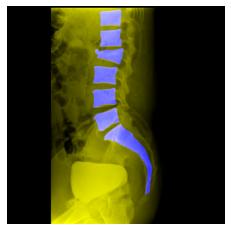

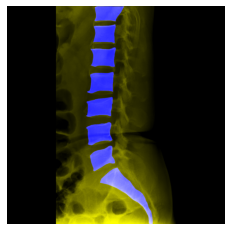

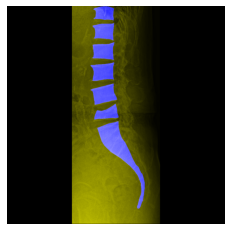

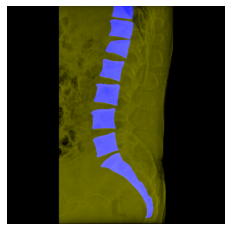

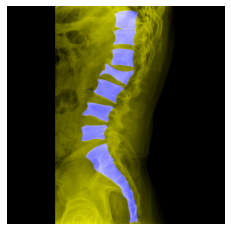

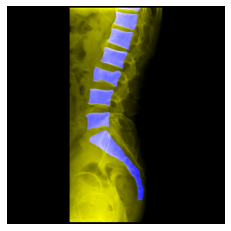

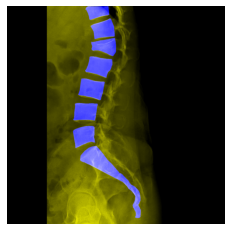

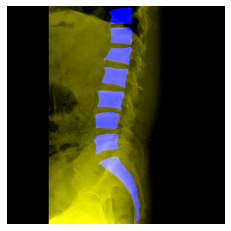

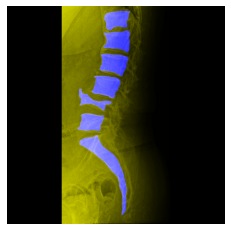

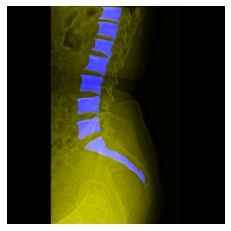

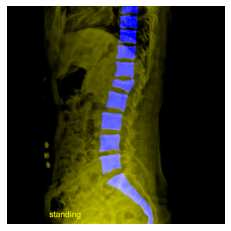

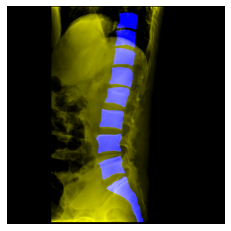

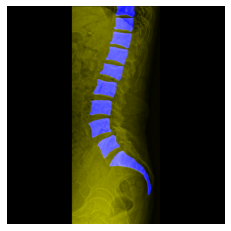

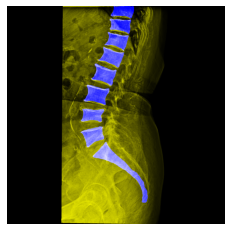

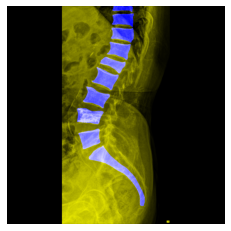

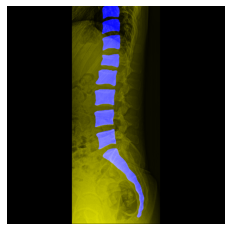

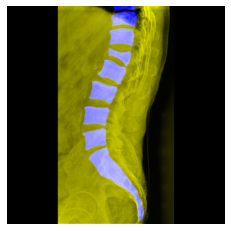

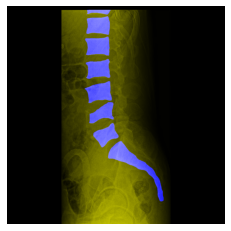

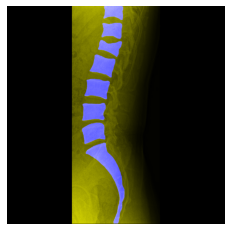

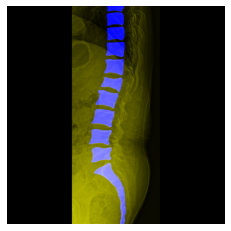

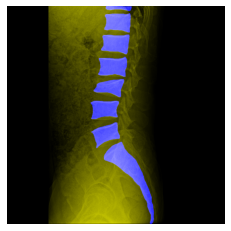

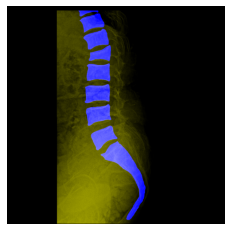

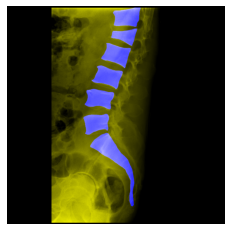

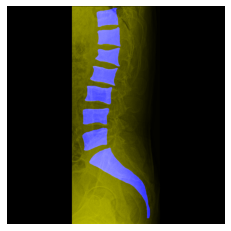

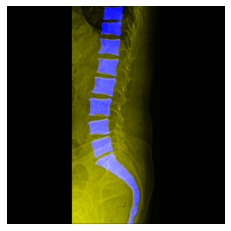

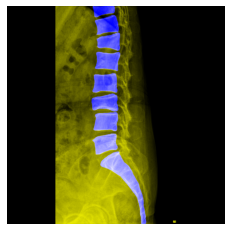

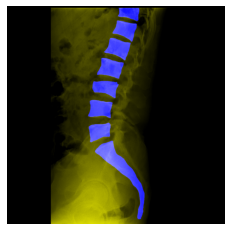

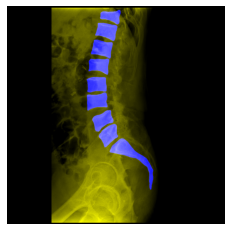

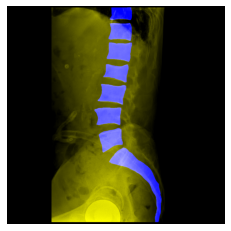

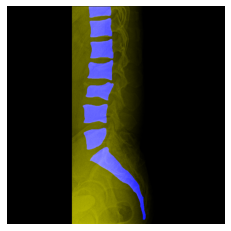

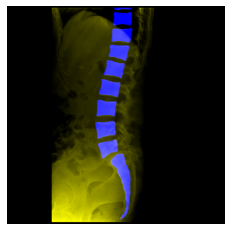

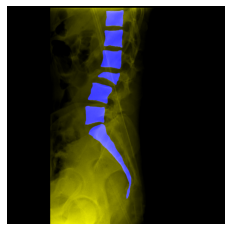

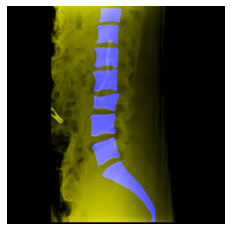

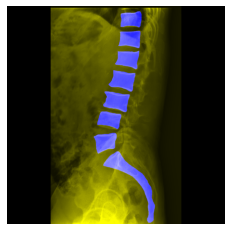

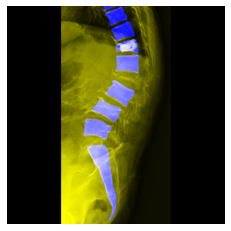

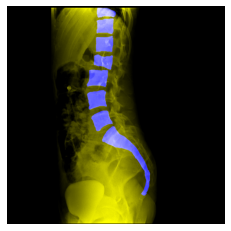

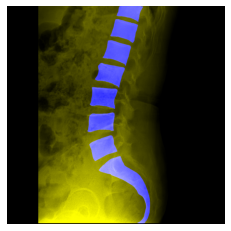

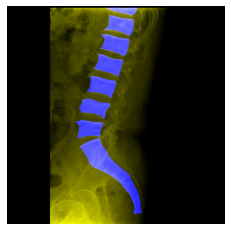

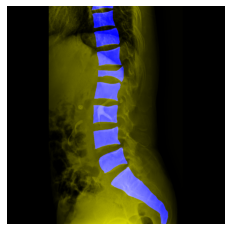

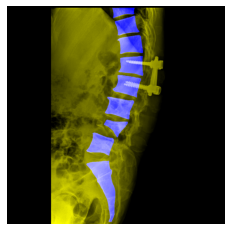

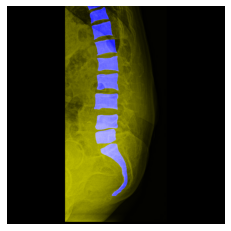

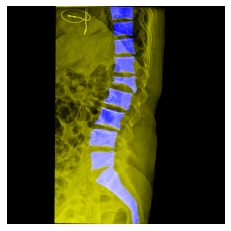

In [137]:
ori_path= sorted(glob.glob('../datasets/3st/inputt/*.png'))
mask_path=sorted(glob.glob('../datasets/3st/maskk/*.png'))
check_path="../datasets/3st/checkk/"

print(len(ori_path),"  ",len(ori_path))
for i in range(len(ori_path)):
    img_name = ori_path[i][ori_path[i].rindex('/')+1:ori_path[i].rindex('.')]
    img_t = load_img(ori_path[i])
    img_l = load_img(mask_path[i])
    x_t = img_to_array(img_t)            
    x_l = img_to_array(img_l)
    x_t[:,:,2] = x_l[:,:,0]
    img_tmp = array_to_img(x_t)
    
    plt.imshow(img_tmp, cmap='gray')
    plt.axis('off')
    plt.show()
    img_tmp.save(check_path+"{}.png".format(img_name))
   

# zip과 dcm 이미지 이름 서로 안맞은거 같을때 검사

In [61]:
# dcm="../datasets/input"
# roi="../datasets/mask"

path="../datasets/ori"
dcm_=glob.glob(path+"/*.dcm")
roi_=glob.glob(path+"/*.zip")

print(len(dcm_))
print(len(roi_))

dcm_f=[]

for i in dcm_: 
    file_=i[i.rindex('/')+1:-4]
    dcm_f.append(file_)


roi_f=[]

for i in roi_: 
    file_1=i[i.rindex('/')+1:-4]
    roi_f.append(file_1)
       

491
491


In [67]:
print(len(set(dcm_f)))
print(len(set(roi_f)))

temp3 = list(set(dcm_f) - set(roi_f))
temp3

# temp3 = []
# for i in dcm_f:
#     if i not in roi_f:
#         temp3.append(i)
# print(temp3)

491
491


[]